1.0 was finding that white patients had higher mortality rates post-discharge than black patients did. That is very unintuitive. Per Alistair, there is a data collection problem in the labels: https://github.com/MIT-LCP/mimic-code/issues/1199

    Q: There is confusion around death dates from MIMIC data.

    A: With MIMIC-III data we had dates of death outside of the hospital stay. However our source of dates of death became extremely poor sometime in ~2013, and so we no longer have it available for the majority of patients in MIMIC-IV. If papers are using 28-day mortality in MIMIC-IV, then they are misleading their readers unless they somewhere clarify it is 28-day mortality within the hospital.

    Q: Did BIDMC stop getting the Social Security Death Index in 2013? Or did they just mess up and not correlate it with their clinical data? Having accurate DOD data has been a real boon to research because it's a more challenging prediction problem post-hospitalization than in-hospital or in-ICU mortality, but somewhat easier than a lot of other clinical prediction problems. Is there some way to get this for MIMIC-IV again? It can't be done by users because one would need access to the SSN, which the hospital has (at least had), but which they certainly can't release.

    A: So.. fun story.. it's actually because of a legislative change which forbid the social security death index from collecting deaths from state databases. The result was a ~40% drop in the capture of deaths - it's no longer of sufficient quality to use as a source of out-of-hospital mortality. I looked into purchasing the data from the CDC, which would cost around $70k USD for MIMIC-IV. Still looking for grant opportunities!

That explains that issue, because when I did a survival surve of patients who died post-discharge, black patients were sicker / dying faster every point of the surve.

For that reason, this notebook, subsets analysis to patients with recorded dates of death. That way, patients who truly died (but it wasnt reflected in the labels) cant bias the training signal.


In [2]:
import psycopg2
import pandas as pd
import tqdm
from collections import Counter, defaultdict
import pylab as pl
import random
import xgboost
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.calibration import calibration_curve
from scipy.stats import mannwhitneyu
from lifelines import KaplanMeierFitter


pd.set_option('display.max_columns', None)

In [3]:
# create a database connection
sqluser = 'wboag'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to the database
con = psycopg2.connect(dbname=dbname, user=sqluser, host="/var/run/postgresql")

# Cohort Creation

In [4]:
# TODO: exclude patients who die in-hospital
cohort_query = '''
WITH T AS (
        SELECT subject_id, MAX(admittime) AS admittime
        FROM mimiciii.admissions 
        GROUP BY subject_id
        ),
     EOL as (
         select hadm_id
         from mimiciii.diagnoses_icd
         where icd9_code = 'V667'
     )
SELECT a.*, gender, dob, dod
FROM mimiciii.admissions a
    JOIN T ON T.subject_id = a.subject_id AND T.admittime = a.admittime
    JOIN mimiciii.patients  p on p.subject_id = a.subject_id
where a.hadm_id not in (select hadm_id from EOL)
and ((dod is null) or (dod :: date - dischtime ::date >= 3))
and a.discharge_location not in ('HOSPICE-HOME', 'HOSPICE-MEDICAL FACILITY', 'DEAD/EXPIRED')
and dod is not null
and (a.admittime :: date - dob ::date) / 365.25 >= 18
--and insurance = 'Medicare'
'''
cohort = pd.read_sql_query(cohort_query, con)
print(cohort.shape)
cohort.head()

(9165, 22)


In [138]:
codestatus_df = pd.read_sql_query('select * from mimiciii.code_status', con)

# get code statuses
codestatus = {}
for row in codestatus_df.itertuples():
    if row.fullcode_last == 1:
        cs = 'fullcode'
    elif row.cmo_last == 1:
        cs = 'cmo'
    elif row.dnr_last == 1:
        cs = 'dnr'
    elif row.dni_last == 1:
        cs = 'dni'
    elif row.dncpr_last == 1:
        cs = 'dncpr'
    else:
        cs = 'none'
        
    codestatus[row.hadm_id] = cs

In [139]:
cmo = set([hadm_id for hadm_id,cs in codestatus.items() if cs=='cmo'])
print(len(cmo))

cohort = cohort[~cohort.hadm_id.isin(cmo)]
print(cohort.shape)

1615
(9144, 22)


In [5]:
demographics_query = 'SELECT distinct subject_id,hadm_id,gender,ethnicity FROM mimiciii.icustay_detail;' 
demographics = pd.read_sql_query(demographics_query, con)

# filter demographics to the patients in the cohort
demographics = demographics[demographics.hadm_id.isin(set(cohort.hadm_id))]

print(demographics.shape)
demographics.head()

(9018, 4)


In [141]:
def normalize_race(race):
    if 'HISPANIC' in race:
        return 'Hispanic'
    if 'SOUTH AMERICAN' in race:
        return 'Hispanic'
    if 'AMERICAN INDIAN' in race:
        return 'Native American'
    if 'ASIAN' in race:
        return 'Asian'
    if 'BLACK' in race:
        return 'Black'
    if 'UNKNOWN/NOT SPECIFIED' in race:
        return 'Not Specified'
    if 'WHITE' in race:
        return 'White'
    #print race
    return 'Other'

demographics['race'] = demographics['ethnicity'].apply(normalize_race)

race_lookup = defaultdict(lambda:'unk')
race_lookup.update(dict(demographics[['hadm_id','race']].values))

# Feature and Labels

In [142]:
# identify who dies within 6 months
died_within_6months = cohort[(cohort.dod - cohort.dischtime) <= pd.Timedelta(days=180)]
died_within_12months = cohort[(cohort.dod - cohort.dischtime) <= pd.Timedelta(days=365)]
died_postdisch = cohort[~cohort.dod.isnull()]

# label every patient as dying within 6 months or not
labels = {hadm_id:0 for hadm_id in cohort.hadm_id}
#for hadm_id in died_within_6months.hadm_id:
for hadm_id in died_within_12months.hadm_id:
#for hadm_id in died_postdisch.hadm_id:
    labels[hadm_id] = 1

print(len(labels))

# print positive percentage
print(sum(labels.values()) / len(labels))

9144
0.5138888888888888


In [143]:
print(len(labels))
print(len(set(demographics.hadm_id)))
print(len(set(cohort.hadm_id)))


9144
8997
9144


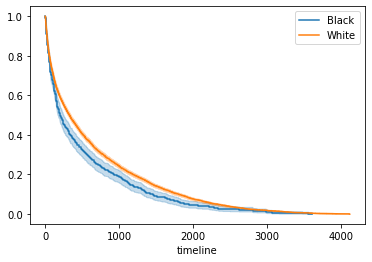

In [144]:
#died_postdisch
died_postdisch['race']  = [race_lookup[row.hadm_id] for row in died_postdisch.itertuples()]
ax = pl.subplot(111)
for race,rows in died_postdisch.groupby('race'):
    if race not in ['White', 'Black']: continue
        
    #print(race)
    #display(rows)
    times  = [t.days for t in (rows.dod - rows.dischtime)]
    
    kmf = KaplanMeierFitter()
    kmf.fit(durations = times, label=race)
    
    kmf.plot_survival_function(ax = ax)


In [145]:
for race in ['White', 'Not Specified', 'Black', 'Other', 'Hispanic', 'Asian']:
    rows = demographics[demographics.race==race]
    group_ids = list(set(rows.hadm_id))
    group_labels   = [labels[pid] for pid in group_ids]
    print(f'{race:15} {sum(group_labels):4}/{len(group_labels):5} ({sum(group_labels)/len(group_labels):.3f})')

White           3492/ 6654 (0.525)
Not Specified    420/ 1086 (0.387)
Black            370/  602 (0.615)
Other            171/  320 (0.534)
Hispanic          81/  177 (0.458)
Asian            104/  153 (0.680)


In [146]:
# Get ICD codes
icd_query = '''
select icd.hadm_id, icd.icd9_code
from mimiciii.DIAGNOSES_ICD icd
inner join mimiciii.d_icd_diagnoses d on d.icd9_code = icd.icd9_code
--limit 500
'''
icd_df = pd.read_sql_query(icd_query, con)
icd_df = icd_df[icd_df.hadm_id.isin(set(cohort.hadm_id))]
print(icd_df.shape)
print(len(set(icd_df.hadm_id)))
icd_df.head()

(108681, 2)
9143


,hadm_id,icd9_code
42,114585,1940
43,114585,1977
44,114585,2553
45,114585,4240
46,114585,5845


In [147]:
d_icd = pd.read_sql_query('select * from mimiciii.d_icd_diagnoses', con)
icd_lookup = dict(d_icd[['icd9_code','long_title']].values)
#icd_lookup = {str(k):v for k,v in icd_df[['icd9_code','short_title']].values}
dict(list(icd_lookup.items())[:3])

{'01166': 'Tuberculous pneumonia [any form], tubercle bacilli not found by bacteriological or histological examination, but tuberculosis confirmed by other methods [inoculation of animals]',
 '01170': 'Tuberculous pneumothorax, unspecified',
 '01171': 'Tuberculous pneumothorax, bacteriological or histological examination not done'}

(0.0, 750.0, 0.0, 1000.0)

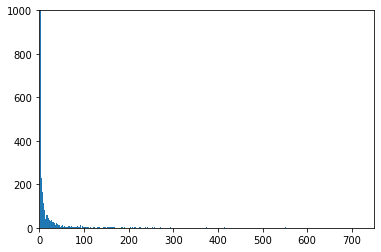

In [148]:
# Frequency of ICDs
icd_freq = Counter(icd_df.icd9_code)

pl.hist(icd_freq.values(), bins=2000)
pl.axis([0, 750, 0, 1000])

In [149]:
features = {}
for hadm_id,rows in tqdm.tqdm(icd_df.groupby('hadm_id')):
    feats = {}
    
    # ICD features
    for icd in rows.icd9_code:
        if icd_freq[icd] > 5:
            feats[icd] = 1
            
    # demographic features
    drows = demographics[demographics.hadm_id==hadm_id]
    if len(drows):
        feats[    f'race={drows.race.values[0]}'] = 1
        feats[f'gender={drows.gender.values[0]}'] = 1
        pass
    
    crows = cohort[cohort.hadm_id==hadm_id]
    feats['age'] = (crows.admittime.values[0] - crows.dob.values[0]) / (np.timedelta64(1, 'D') * 365.25)
    
    features[hadm_id] = feats
    
print(len(features))

100%|██████████| 9143/9143 [00:11<00:00, 810.35it/s]

9143


# ML Model

In [151]:
ids = list(set(features.keys()) & set(labels.keys()))
random.shuffle(ids)

ind = int(0.7 * len(ids))
train_ids = ids[:ind]
test_ids  = ids[ ind:]

print(len(train_ids), len(test_ids))

6400 2743


In [152]:
train_features = [features[hadmid] for hadmid in train_ids]
test_features  = [features[hadmid] for hadmid in  test_ids]

train_labels = [labels[hadmid] for hadmid in train_ids]
test_labels  = [labels[hadmid] for hadmid in  test_ids]

In [153]:
vect = DictVectorizer()
vect.fit(train_features)

DictVectorizer()

In [154]:
train_X = vect.transform(train_features)
test_X  = vect.transform( test_features)

print(train_X.shape)
print(test_X.shape)

(6400, 1422)
(2743, 1422)


In [155]:
xgb = xgboost.XGBClassifier(eval_metric='logloss')
xgb.fit(train_X, train_labels)

/afs/csail.mit.edu/u/w/wboag/.conda/envs/wb/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Evaluation

In [156]:
def evaluate_performance(labels, preds, thr=None):
    #print('AAA:', len(labels), len(preds))
    
    if not thr:
        n = int(0.9*len(preds))
        thr = sorted(preds)[n]
        
    preds_thr = [int(p>=thr) for p in preds]
    
    # confusion matrix
    tp,fp,fn,tn = 0,0,0,0
    for ref,pred in zip(labels,preds_thr):
        if   ref==0 and pred==0: tn += 1
        elif ref==0 and pred==1: fp += 1
        elif ref==1 and pred==0: fn += 1
        elif ref==1 and pred==1: tp += 1
    conf = {'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn}
    recall    = float(tp) / (tp+fn+1e-9)
    precision = float(tp) / (tp+fp+1e-9)
    #print(conf)
    #print(recall)
    
    # AUC
    #print(labels)
    #print(preds)
    auc = roc_auc_score(labels, preds)
            
    results = {'recall':recall, 'precision':precision, 'auc':auc, 'conf':conf}
    return results

In [157]:
test_pred = xgb.predict_proba(test_X)[:,1]

print(test_pred.shape)

(2743,)


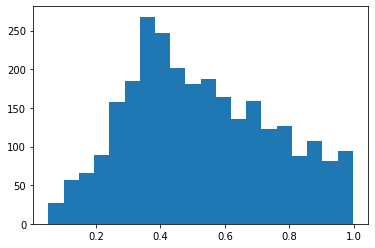

In [158]:
pl.hist(test_pred, bins=20)
pl.show()

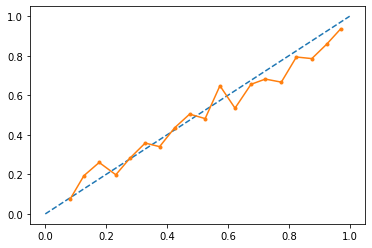

In [159]:
# reliability diagram
fop, mpv = calibration_curve(test_labels, test_pred, n_bins=20)
# plot perfectly calibrated
pl.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pl.plot(mpv, fop, marker='.')
pl.show()

In [160]:
# Overall AUC
roc_auc_score(test_labels, test_pred)

0.7230120314058834

White           (n=1973) R=184/1036(0.178)   P=184/ 216(0.852)   AUC=0.716


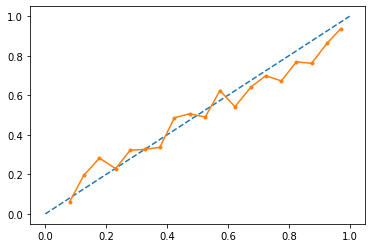

Not Specified   (n= 330) R=  9/ 113(0.080)   P=  9/   9(1.000)   AUC=0.735


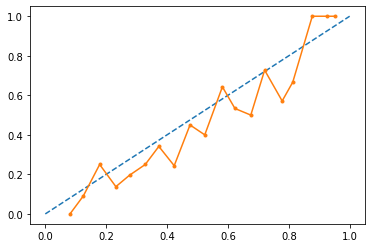

Black           (n= 178) R= 15/ 106(0.142)   P= 15/  17(0.882)   AUC=0.683


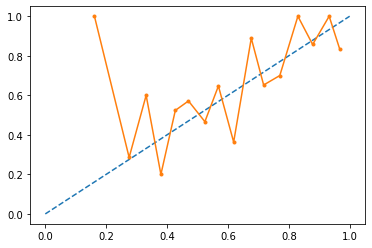

Other           (n=  93) R=  5/  52(0.096)   P=  5/   8(0.625)   AUC=0.694


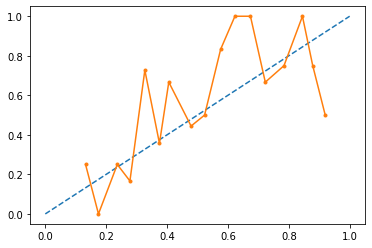

Hispanic        (n=  63) R=  5/  28(0.179)   P=  5/   5(1.000)   AUC=0.699


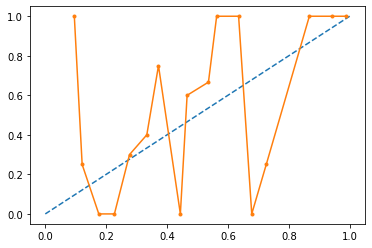

Asian           (n=  61) R= 12/  42(0.286)   P= 12/  14(0.857)   AUC=0.617


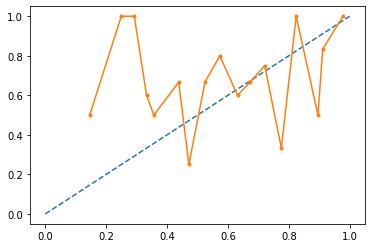

In [161]:
# Per race recall @ top-10%
n = int(0.9*len(test_pred))
thr = sorted(test_pred)[n]

test_demographics = demographics[demographics.hadm_id.isin(test_ids)]
for race in ['White', 'Not Specified', 'Black', 'Other', 'Hispanic', 'Asian']:
    #print(race)
    #display(rows)
    rows = test_demographics[test_demographics.race==race]
    group_ids = list(set(rows.hadm_id))
    group_features = [features[pid] for pid in group_ids]
    group_X = vect.transform(group_features)
    group_labels   = [labels[pid]   for pid in group_ids]
    group_pred = xgb.predict_proba(group_X) [:,1]
    
    results = evaluate_performance(group_labels, group_pred, thr=thr)
    conf = results['conf']
    tp,fp,fn,tn = conf['TP'], conf['FP'], conf['FN'], conf['TN']
    auc       = results['auc']
    precision = results['precision']
    recall    = results['recall']
    
    print(f'{race:15} (n={len(group_ids):4}) R={tp:3d}/{tp+fn:4}({recall:.3f})   P={tp:3d}/{tp+fp:4}({precision:.3f})   AUC={auc:.3f}')

    # reliability diagram
    fop, mpv = calibration_curve(group_labels, group_pred, n_bins=20)
    # plot perfectly calibrated
    pl.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pl.plot(mpv, fop, marker='.')
    pl.show()
    
    #break

In [162]:
# Most informative features
svm = LinearSVC()
svm.fit(train_X, train_labels)

# map the dimensions to names
ind2feat =  { i:f for f,i in vect.vocabulary_.items() }

# create a 2-by-m matrix for biary, rather than relying on 1-p bullshit
coef_ = svm.coef_[0,:]

# most informative features
informative_feats = np.argsort(coef_)

#'''
# display what each feature is
for dim in list(reversed(informative_feats))[:25]:
    val = coef_[dim]

    word = ind2feat[dim]
    desc = icd_lookup[word]
    print(f'[{word[:3]+"."+word[3:]:6s}] [{desc[:50]:52}]: {val}')
    
print('\n')

for dim in list(reversed(informative_feats))[-25:]:
    val = coef_[dim]

    word = ind2feat[dim]
    desc = icd_lookup[word]
    print(f'[{word[:3]+"."+word[3:]:6s}] [{desc[:50]:52}]: {val}')

[191.2 ] [Malignant neoplasm of temporal lobe                 ]: 0.9251133801923446
[723.1 ] [Cervicalgia                                         ]: 0.8918201917861572
[157.8 ] [Malignant neoplasm of other specified sites of pan  ]: 0.8606433760727977
[155.1 ] [Malignant neoplasm of intrahepatic bile ducts       ]: 0.7567797909307156
[322.9 ] [Meningitis, unspecified                             ]: 0.7366757887175381
[284.89] [Other specified aplastic anemias                    ]: 0.7255259409967015
[191.1 ] [Malignant neoplasm of frontal lobe                  ]: 0.7234889408205091
[V49.86] [Do not resuscitate status                           ]: 0.7087033199568555
[251.1 ] [Other specified hypoglycemia                        ]: 0.6973531437729409
[292.12] [Drug-induced psychotic disorder with hallucination  ]: 0.6885468468473996
[623.8 ] [Other specified noninflammatory disorders of vagin  ]: 0.6854728797206817
[478.29] [Other diseases of pharynx, not elsewhere classifie  ]: 0.685216684

/afs/csail.mit.edu/u/w/wboag/.conda/envs/wb/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [163]:
for dim in list(reversed(informative_feats))[:25]:
    word = ind2feat[dim]
    desc = icd_lookup[word]
    
    # Look at prevalance in W vs B population
    pt_nums = train_X[:,dim].nonzero()[0]
    hadm_ids = [train_ids[ptnum] for ptnum in pt_nums]
    group_labels = [labels[hadm_id] for hadm_id in hadm_ids]
    frac_mort = float(sum(group_labels)) / len(group_labels)
    group_demographics = demographics[demographics.hadm_id.isin(hadm_ids)]

    print(f'[{word[:3]+"."+word[3:]:6s}] [{desc[:50]:52}] mort={sum(group_labels):2}/{len(group_labels):2} ({frac_mort:.3})')
    for race,rows in group_demographics.groupby('race'):
        print(f'\t{race:15}: n={len(rows)}')
    #display(group_demographics)
    
    #break

[191.2 ] [Malignant neoplasm of temporal lobe                 ] mort=14/16 (0.875)
	Black          : n=1
	Other          : n=1
	White          : n=12
[723.1 ] [Cervicalgia                                         ] mort= 5/ 6 (0.833)
	White          : n=6
[157.8 ] [Malignant neoplasm of other specified sites of pan  ] mort=29/32 (0.906)
	Asian          : n=2
	Black          : n=3
	Not Specified  : n=1
	Other          : n=1
	White          : n=24
[155.1 ] [Malignant neoplasm of intrahepatic bile ducts       ] mort=17/19 (0.895)
	Asian          : n=2
	Hispanic       : n=1
	White          : n=16
[322.9 ] [Meningitis, unspecified                             ] mort= 7/ 7 (1.0)
	Asian          : n=1
	Black          : n=1
	White          : n=5
[284.89] [Other specified aplastic anemias                    ] mort=11/11 (1.0)
	Black          : n=1
	White          : n=10
[191.1 ] [Malignant neoplasm of frontal lobe                  ] mort=13/16 (0.812)
	White          : n=15
[V49.86] [Do not resus

In [164]:
for dim in list(reversed(informative_feats))[-25:]:
    word = ind2feat[dim]
    desc = icd_lookup[word]
    
    # Look at prevalance in W vs B population
    pt_nums = train_X[:,dim].nonzero()[0]
    hadm_ids = [train_ids[ptnum] for ptnum in pt_nums]
    group_labels = [labels[hadm_id] for hadm_id in hadm_ids]
    frac_mort = float(sum(group_labels)) / len(group_labels)
    group_demographics = demographics[demographics.hadm_id.isin(hadm_ids)]

    print(f'[{word[:3]+"."+word[3:]:6s}] [{desc[:50]:52}] mort={sum(group_labels):2}/{len(group_labels):2} ({frac_mort:.3})')
    for race,rows in group_demographics.groupby('race'):
        print(f'\t{race:15}: n={len(rows)}')
    #display(group_demographics)
    
    #break

[338.18] [Other acute postoperative pain                      ] mort= 2/ 7 (0.286)
	Other          : n=1
	White          : n=6
[442.2 ] [Aneurysm of iliac artery                            ] mort= 0/14 (0.0)
	Black          : n=1
	Not Specified  : n=1
	White          : n=12
[211.1 ] [Benign neoplasm of stomach                          ] mort= 1/ 9 (0.111)
	Black          : n=1
	Hispanic       : n=1
	Native American: n=1
	White          : n=6
[410.31] [Acute myocardial infarction of inferoposterior wal  ] mort= 2/19 (0.105)
	Black          : n=1
	Not Specified  : n=7
	White          : n=11
[305.03] [Alcohol abuse, in remission                         ] mort= 5/12 (0.417)
	Black          : n=1
	Not Specified  : n=1
	White          : n=10
[907.2 ] [Late effect of spinal cord injury                   ] mort= 2/10 (0.2)
	Black          : n=1
	Hispanic       : n=1
	Not Specified  : n=2
	White          : n=6
[481.  ] [Pneumococcal pneumonia [Streptococcus pneumoniae p  ] mort= 4/18 (0.222)
	B

In [165]:
# Run multiple times
aucs    = {'Black':[], 'White':[]}
recalls = {'Black':[], 'White':[]}
for i in tqdm.tqdm(range(20)):
    # Randomly split data
    ids = list(set(features.keys()) & set(labels.keys()))
    random.shuffle(ids)
    ind = int(0.7 * len(ids))
    train_ids = ids[:ind]
    test_ids  = ids[ ind:]

    # train/test separation
    train_features = [features[hadmid] for hadmid in train_ids]
    test_features  = [features[hadmid] for hadmid in  test_ids]

    train_labels = [labels[hadmid] for hadmid in train_ids]
    test_labels  = [labels[hadmid] for hadmid in  test_ids]
    
    # vectorizer
    vect = DictVectorizer()
    vect.fit(train_features)
    train_X = vect.transform(train_features)
    test_X  = vect.transform( test_features)
    
    # fit model
    xgb = xgboost.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
    xgb.fit(train_X, train_labels)
    
    # threshold across groups
    test_pred = xgb.predict_proba(test_X) [:,1]
    n = int(0.9*len(test_pred))
    thr = sorted(test_pred)[n]
    
    # predict and eval for black vs white
    test_demographics = demographics[demographics.hadm_id.isin(test_ids)]
    for race in ['White', 'Black']:
        rows = test_demographics[test_demographics.race==race]
        group_ids = list(set(rows.hadm_id))
        group_features = [features[pid] for pid in group_ids]
        group_X = vect.transform(group_features)
        group_labels   = [labels[pid]   for pid in group_ids]
        group_pred = xgb.predict_proba(group_X) [:,1]

        results = evaluate_performance(group_labels, group_pred, thr=thr)
        aucs[race].append(results['auc'])
        recalls[race].append(results['recall'])
        
    
    #break
    
#print(aucs)
#print()
print('AUC')
for race in ['White', 'Black']:
    print(f'{race}: {np.mean(aucs[race])} +/- {np.std(aucs[race])}')
    for auc in aucs[race]:
        print(f'\t{auc}')
    print()
    
print('Recall')
for race in ['White', 'Black']:
    print(f'{race}: {np.mean(recalls[race])} +/- {np.std(recalls[race])}')
    for r in recalls[race]:
        print(f'\t{r}')
    print()

100%|██████████| 20/20 [04:07<00:00, 12.40s/it]

AUC
White: 0.7158867920118116 +/- 0.009647628722172038
	0.7036558591107618
	0.7089241746286237
	0.7116633366633367
	0.7274149240580594
	0.6920956998171024
	0.7056728451540699
	0.7186565039203523
	0.7295962186532423
	0.7052119601734774
	0.7131305661672835
	0.7165481900479641
	0.713981638589262
	0.7192883202558848
	0.7238540258079132
	0.7241712059628673
	0.727524293303498
	0.7218239644104505
	0.7271039255866281
	0.7196874006870181
	0.7077307872384386

Black: 0.669380141173274 +/- 0.02817248567476665
	0.6393902105550998
	0.6086319585305386
	0.702028541101545
	0.6901098901098901
	0.6924590163934425
	0.6482420554428667
	0.6950454487261554
	0.6960156032320981
	0.6691361916771752
	0.6762121212121213
	0.697203196347032
	0.7305779569892473
	0.6709956709956709
	0.6379310344827587
	0.6748200479872034
	0.6476601544752385
	0.6612153278819947
	0.6404925847457626
	0.6496861419604056
	0.6597496706192358

Recall
White: 0.17425566273939636 +/- 0.005898880573961627
	0.16634799235165743
	0.164092664092505

In [166]:
# Aversge risk score per race

# Per race recall @ top-10%
n = int(0.9*len(test_pred))
thr = sorted(test_pred)[n]

test_demographics = demographics[demographics.hadm_id.isin(test_ids)]
scores = {}
for race in ['White', 'Black']:
    #print(race)
    #display(rows)
    rows = test_demographics[test_demographics.race==race]
    group_ids = list(set(rows.hadm_id))
    group_features = [features[pid] for pid in group_ids]
    group_X = vect.transform(group_features)
    group_labels   = [labels[pid]   for pid in group_ids]
    group_pred = xgb.predict_proba(group_X) [:,1]
    scores[race] = group_pred

		white: 2055 0.50237024
		black: 157 0.64932305
		p-value: 9.169322729638583e-10


<ipython-input-167-fd7ff894758e>:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pl.subplot(111)


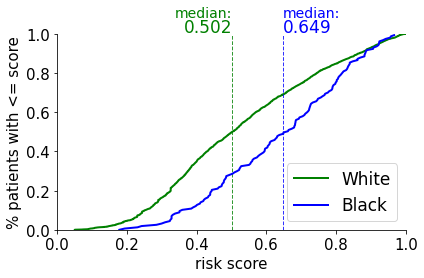

In [167]:
def list_median(vals):
    svals = sorted(vals)
    return svals[int(len(svals)/2)]


def plot_distributions(dists):
    fig = pl.figure()

    p1 = list(dists['White'])
    p2 = list(dists['Black'])
    
    white_median = list_median(p1)
    black_median = list_median(p2)
    smaller_median = min(white_median, black_median)

    #colors = ['#00A6ED', '#FF5400']
    colors = ['green', 'blue']
    for i,race in enumerate(['White', 'Black']):
        vals = list(dists[race])
        pl.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label=race, lw=2)
        #pl.xlim((0,0.4))
        pl.xlim((0,1.0))
        pl.ylim((0,1.0))

        median = list_median(vals)
        pl.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
        if median == smaller_median:
            p = .001
            h = 'right'
        else:
            p = -.001
            h = 'left'
        #h = 'center'
        pl.text(x=median+p, y=1.085, horizontalalignment=h, s="median:"      , fontsize=14, color=colors[i])
        pl.text(x=median+p, y=1.01 , horizontalalignment=h, s=f'{median:.3f}', fontsize=17, color=colors[i])


    ax = pl.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    pl.yticks(fontsize=15)    
    pl.xticks(fontsize=15) 

    pl.legend(loc=4, fontsize=17)
    pl.ylabel("% patients with <= score", fontsize=15)
    pl.xlabel('risk score', fontsize=15)

    pl.tight_layout()

    w = mannwhitneyu(p1, p2)
    print('\t\twhite:', len(p1), white_median)
    print('\t\tblack:', len(p2), black_median)
    print('\t\tp-value:', w.pvalue)
    pl.show()
    

    
plot_distributions(scores)

In [168]:
# TODO: could build model to distinguish black vs white (to see what top separators are)
pass